# Calculate and plot composites of velocity potential anomalies for ENSO phases

## 1. Load modules

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

## 2. Read niño3.4 index

In [2]:
# Read index
df = pd.read_csv('nina34.anom.data', sep=r'\s+', header=None)
df.columns = ['years'] + [f'{month}' for month in range(1, 13)]
# df

In [3]:
years = np.arange(1980,2015)
nyr = len(years)
nino34_Jan = df['1'][(df['years'] >= 1980) & (df['years'] <= 2014)]

In [4]:
id_el = np.where(nino34_Jan>=1)
id_la = np.where(nino34_Jan<=-1)
id_ne = np.where((nino34_Jan>-1) &(nino34_Jan<1))

In [5]:
year_el = years[id_el]
year_la = years[id_la]
year_ne = years[id_ne]
counts = [len(year_el),len(year_la),len(year_ne)]

In [6]:
print(year_el)
print(year_la)
print(year_ne)

[1983 1987 1992 1995 1998 2010]
[1985 1989 1999 2000 2008 2011]
[1980 1981 1982 1984 1986 1988 1990 1991 1993 1994 1996 1997 2001 2002
 2003 2004 2005 2006 2007 2009 2012 2013 2014]


## 3. Define a new function

In [7]:
def get_anomaly(fname,idir):
    ds = xr.open_dataset(fname)
    lat = ds['lat'].sel(lat=slice(-30,30))
    lon = ds['lon']
    nlat = len(lat)
    nlon = len(lon)

    time = ds['time']
    ntime = len(time)
    vp_array = np.empty((nyr,ntime,nlat,nlon),dtype=np.float32)
    for n, year in enumerate(years):
        vp_path = idir+f'vp200_{year}01.nc'
        ds_vp = xr.open_dataset(vp_path)
        vp_array[n,:,:,:] = ds_vp['vp200'].sel(lat=slice(-30, 30))
    vp_array = xr.DataArray(vp_array,dims=['years','time','lat','lon'],
                           coords={'years': years,
                                  'time': time,
                                  'lat': lat,
                                  'lon': lon}, name = 'vp')
    vp_clim = vp_array.mean('years')
    vp_ano = vp_array[:,:31,:,:] - vp_clim
    ano_el = vp_ano.sel(years=year_el)
    ano_la = vp_ano.sel(years=year_la)
    ano_ne = vp_ano.sel(years=year_ne)
    ano = [ano_el, ano_la, ano_ne]
    
    ano_el_yr = ano_el.mean(dim="time").mean(dim="years")
    ano_la_yr = ano_la.mean(dim="time").mean(dim="years")
    ano_ne_yr = ano_ne.mean(dim="time").mean(dim="years")
    comp_ano = [ano_el_yr, ano_la_yr, ano_ne_yr]
    
    diff_el = ano_el_yr - ano_ne_yr
    diff_la = ano_la_yr - ano_ne_yr
    diff = [diff_el,diff_la]
    
    return comp_ano, diff, vp_ano, ano

## 4. Read model data

In [8]:
# velocity potential data
idir_m = '/scratch/jjung45/mjo/vp200/'
fname_m = idir_m + 'vp200_200801.nc' #float prate(ens,time,lat,lon); mm/day
 
idir_e = '~/_scratch/ERA5/daily/vp200/'
fname_e = idir_e + 'vp200_200801.nc'

In [9]:
comp_ano_m, diff_m, vp_ano_m, ano_m = get_anomaly(fname_m,idir_m)
comp_ano_e, diff_e, vp_ano_e, ano_e = get_anomaly(fname_e,idir_e)

In [10]:
lat_m = ano_m[0]['lat']
lon_m = ano_m[0]['lon']

lat_e = ano_e[0]['lat']
lon_e = ano_e[0]['lon']

## 5. Plot the composites of velocity potential anomalies

In [11]:
def set_latlon(ax,ln_l,ln_r,ln_iv,lt_b,lt_u,lt_iv):
    # longitude label
    ax.set_xticks(np.arange(ln_l,ln_r+1,ln_iv), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    # latitude label
    ax.set_yticks(np.arange(lt_b,lt_u+1,lt_iv), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    # gridline
    gl = ax.gridlines(ylocs=np.arange(lt_b,lt_u+1,lt_iv),draw_labels=False, 
                      linestyle='--',linewidth=0.6, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False


### 1) Composite map of velocity potential anomalies for each ENSO phase

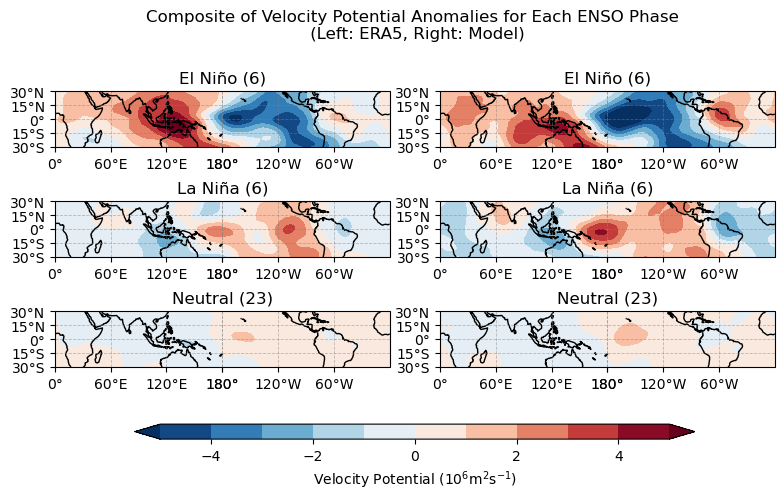

In [12]:
labels=['El Niño','La Niña', 'Neutral']
clevs = np.arange(-5,6,1)

# Define the figure and each axis for the 1 rows and 3 columns
fig, axs = plt.subplots(nrows=3,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                        figsize=(8,10))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
#axs = axs.flatten()

#Loop over all of the cases and plot
for i,enso in enumerate(comp_ano_m):

        # Select the case
        data_m = comp_ano_m[i]*1e-06
        data_e = comp_ano_e[i]*1e-06

        # Add the cyclic point
        data_m,lons_m = add_cyclic_point(data_m,coord=lon_m)
        data_e,lons_e = add_cyclic_point(data_e,coord=lon_e)

        # Contour plot
        cs=axs[i,0].contourf(lons_e,lat_e,data_e,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap=plt.cm.RdBu_r,extend='both')
        cs=axs[i,1].contourf(lons_m,lat_m,data_m,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap=plt.cm.RdBu_r,extend='both')

        set_latlon(axs[i,0],-180,180,60,-30,30,15)
        set_latlon(axs[i,1],-180,180,60,-30,30,15)
        # Title each subplot with the name of the season
        axs[i,0].set_title(labels[i] + ' ('+str(counts[i])+')')
        axs[i,1].set_title(labels[i] + ' ('+str(counts[i])+')')

        # Draw the coastines for each subplot
        axs[i,0].coastlines()
        axs[i,1].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.4, top=1.12, left=0.05, right=0.95,
                    wspace=0.15, hspace=-0.78)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.15, 0.55, 0.7, 0.015])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal'
                    ,label="Velocity Potential ($10^6$m$^2$s$^{-1}$)")

# Add a big title at the top
plt.suptitle('Composite of Velocity Potential Anomalies for Each ENSO Phase \n (Left: ERA5, Right: Model)') ;
plt.savefig(f'plot_map_comp_anom_each_ph.png',dpi=300,bbox_inches="tight", pad_inches=0.1)

## 6.Significance Testing 

In [13]:
# Load additional required modules
from scipy.stats import ttest_ind

In [14]:
# Model
test1_m = vp_ano_m.mean(dim="time")
test2_m = ano_m[0].mean(dim="time")
test3_m = ano_m[1].mean(dim="time")
tstat1_m, pval1_m = ttest_ind(test2_m, test1_m, equal_var = False)
tstat2_m, pval2_m = ttest_ind(test3_m, test1_m, equal_var = False)

# ERA5
test1_e = vp_ano_e.mean(dim="time")
test2_e = ano_e[0].mean(dim="time")
test3_e = ano_e[1].mean(dim="time")
tstat1_e, pval1_e = ttest_ind(test2_e, test1_e, equal_var = False)
tstat2_e, pval2_e = ttest_ind(test3_e, test1_e, equal_var = False)

In [15]:
p = 0.05 
# Model
mask_diff1_m = diff_m[0].where(pval1_m <= p)
mask_diff2_m = diff_m[1].where(pval2_m <= p)
mask_diff_m = [mask_diff1_m, mask_diff2_m]
# ERA5
mask_diff1_e = diff_e[0].where(pval1_e <= p)
mask_diff2_e = diff_e[1].where(pval2_e <= p)
mask_diff_e = [mask_diff1_e, mask_diff2_e]

### 2) Composite differences in velocity potential anomalies across ENSO phases with a significance test

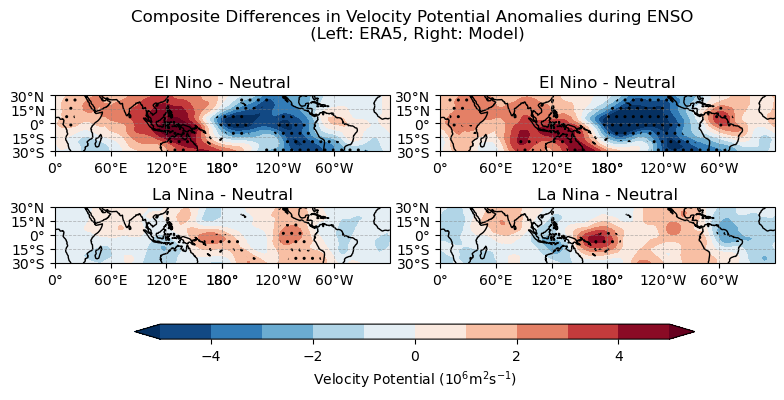

In [16]:
labels=['El Nino - Neutral','La Nina - Neutral']
clevs = np.arange(-5,6,1)
hatch_levs=[0]

# Define the figure and each axis for the 1 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                        figsize=(8,10))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
# axs = axs.flatten()

#Loop over all of the cases and plot
for i,enso in enumerate(diff_m):

        # Select the case
        data_m = diff_m[i]*1e-06
        data_e = diff_e[i]*1e-06

        # Add the cyclic point
        data_m,lons_m = add_cyclic_point(data_m, coord=lon_m)
        mask_data_m,lons_m = add_cyclic_point(mask_diff_m[i], coord=lon_m)
        data_e,lons_e = add_cyclic_point(data_e, coord=lon_e)
        mask_data_e,lons_e = add_cyclic_point(mask_diff_e[i], coord=lon_e)

        # Contour plot
        cs=axs[i,0].contourf(lons_e, lat_e, data_e, clevs,
                             transform = ccrs.PlateCarree(),
                             cmap=plt.cm.RdBu_r, extend='both')
        ss=axs[i,0].contourf(lons_e, lat_e, mask_data_e, [0,1],
                             transform = ccrs.PlateCarree(),colors=['None'],
                             hatches=['..',''],extend='both',alpha=0.0)
        
        cs=axs[i,1].contourf(lons_m, lat_m, data_m, clevs,
                             transform = ccrs.PlateCarree(),
                             cmap=plt.cm.RdBu_r, extend='both')
        ss=axs[i,1].contourf(lons_m, lat_m, mask_data_m, [0,1],
                             transform = ccrs.PlateCarree(),colors=['None'],
                             hatches=['..',''],extend='both',alpha=0.0)

        # To set lat, lon axis
        set_latlon(axs[i,0],-180,180,60,-30,30,15)
        set_latlon(axs[i,1],-180,180,60,-30,30,15)

        # Title each subplot with the name of the season
        axs[i,0].set_title(labels[i])
        axs[i,1].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i,0].coastlines()
        axs[i,1].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.5, top=1.12, left=0.05, right=0.95,
                    wspace=0.15, hspace=-0.78)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.15, 0.65, 0.7, 0.015])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal'
                    ,label="Velocity Potential ($10^6$m$^2$s$^{-1}$)")

# Add a big title at the top
plt.suptitle('Composite Differences in Velocity Potential Anomalies during ENSO \n (Left: ERA5, Right: Model)') ;
plt.savefig(f'plot_map_comp_diff_anom.png',dpi=300,bbox_inches="tight", pad_inches=0.1)